# NAME: Jaime LIMA (jdl679 N17822573)
# ML 6143 Prof Sundeep Ragan
# PRJOECT: NITS CBRS RADAR 3.5 GHz Waveform Detection

# RadarWaveformsML - Detecting the Presence of the Waveform Immersed in Gaussian Noise using PCA
Manipulation of Radar and Communication Waveforms using new ML algorithms but not forgetting the Old Tricks

This repository was originally created for project for the Class "Introduction to Machine Learning at NYU Tandon" ministered by Professor Sundeep Ragan (more details at https://github.com/sdrangan/introml)

The main goal is to use synthetic radar waveforms (**RF Dataset of Incumbent Radar Systems in the 3.5 GHz CBRS Band**) provided by the scientists at the US National Institute of Standards and Technology (NIST) (more details at https://data.nist.gov/od/id/mds2-2116) to investigate the detection of features in the waveforms using *Machine Learning* techniques.

We are interested in simple trainable algorithms that able to detect the waveforms in the presence of noise (and also fading in the future). We are also interested in find the *signatures* of the waveforms to be able to classify the different radar waveforms and differentiate them from other electromagnetic signals, like the ones used for microwave wireless communications. 

Real-time time identification of waveforms is an important tool that can be used to allow coexistence of different emitters sharing the same geographical space. It is also relevant for cyber-security, helping to assure security in cyber-physical environments.

NOTE: to develop the code here we used examples provided in the NIST directory about how read the data files and label files fields correctly in the Python Programming Language. The MATLAB code used by the scientists at NIST to generated radar wavforms simililar to the ones they made avaiable can be found at 

https://github.com/usnistgov/SimulatedRadarWaveformGenerator.git/trunk

NIST Data Website
https://data.nist.gov/od/id/mds2-2116

Contact: Raied Caromi.. 
Raied Caromi
Email: raied.caromi@nist.gov




## Importing some Libraries


In [ ]:
import numpy as np
import h5py
from   pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
GDRIVE_MOUNTED=False

# Some Details about How to Dowload RF Dataset of Incumbent Radar Systems in the 3.5 GHz CBRS Band

Each file has 200 synthetically created waveforms, each being 80 ms long. Some waveorms have only gaussian noise. Others have radar waveforms immersered in gaussian noise under several different SNR. Radar waveforms can be different types of simple pulse trains or more complex chirped waveforms.

Each file size is 2.5 GB. The total dataset is 500 GB! We will use just a few files from the database. Additional small csv files provide different types of labels related to the data.

The data can be download directly from NIST using the link https://data.nist.gov/od/id/mds2-2116

For convencience, a subset of of the data was downloaded in the Google drive and is accessible for people from NYU. The shared link below provides access to the NYU folks. The shared folder has the same structure as the NIST database but only few of the large waveform files.

https://drive.google.com/drive/folders/1IhVG7mAMoTFjsXbArvrz3cEIXDIJVnDS?usp=sharing

Once the code is copied into the person google drive, the code below can be easily adjusted to access the data by chaning the variables *data_folder* and *remote_folder_gdrive*. The code below also allows to run the iphython notebook locally in the machine. In this case the variable *remote_folder_local* needs to be udpated

The code below also checks if GPU is enabled.

In [ ]:
str_GPU='GPU'
#str_GPU='CPU' #To fake having a GPU
data_folder="SimulatedRadarWaveforms" 
remote_folder_gdrive="./gdrive/My Drive/_BIG1/NIST/CBRS/"+data_folder 
remote_folder_local="/G/_BIG1/NIST/CBRS/"+data_folder

import os
#!df -k | egrep "Filesystem|overlay"
#!ls

# MOUNT GDRIVE
if 'google.colab' in str(get_ipython()):
  GCOLAB_ENV=True
  print('***RUNNING on CoLab')
  if False==GDRIVE_MOUNTED:
    from google.colab import drive
    drive.mount("/content/gdrive")
    GDRIVE_MOUNTED=True
else:
  print('***NOT RUNNING on CoLab')
  GCOLAB_ENV=False

# CHECK if System has GPU
from tensorflow.python.client import device_lib
resp = device_lib.list_local_devices()
if str_GPU in str(resp):    
  has_gpu=True
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0: print('GPU Info NOT AVAILABLE (!?!)')
  else:                            print(gpu_info)
else:                       
  has_gpu=False   

# LOAD Data
if True==GCOLAB_ENV:
  data_folder_full = remote_folder_gdrive
  #!rsync -av "$remote_folder"   .
  #!du        "$data_folder"
  #!rsync -av "$data_folder"     .
else:
  data_folder_full = remote_folder_local

print('Data Folder:', data_folder_full)
!ls -l     "$data_folder_full"    
    
!rm -rf ./flickr2
if (True==has_gpu): 
  print("*** DO SOMETHING (HAS GPU)")
else:
  print("*** DO SOMETHING (HAS NO GPU)")


***RUNNING on CoLab
Mounted at /content/gdrive
Data Folder: ./gdrive/My Drive/_BIG1/NIST/CBRS/SimulatedRadarWaveforms
total 3800
-rw------- 1 root root 3864830 Nov 19 04:01 allWaveformsTableCombined.csv
-rw------- 1 root root      64 Nov 19 04:01 allWaveformsTableCombined.csv.sha256
drwx------ 2 root root    4096 Nov 19 04:01 Group1
drwx------ 2 root root    4096 Nov 19 13:17 Group2
drwx------ 2 root root    4096 Nov 19 13:17 Group3
drwx------ 2 root root    4096 Nov 19 13:18 Group4
-rw------- 1 root root    2282 Nov 19 13:04 License.txt
-rw------- 1 root root      64 Nov 19 13:04 License.txt.sha256
-rw------- 1 root root    1399 Nov 19 04:01 ReadMe.txt
-rw------- 1 root root      64 Nov 19 13:04 ReadMe.txt.sha256
drwx------ 2 root root    4096 Nov 19 04:01 readWaveformsCodeExamples
*** DO SOMETHING (HAS NO GPU)


## Reading the Radar Waveform Data Set .mat files and the .csv file with the Additional Labels

This will take some time because the files are large.

In [ ]:
#dataRootFolder=data_folder
group_No =1  # 1 to 4
subset_No=2 # 1 to 50
# Preps
dataRootFolder  =data_folder_full
fileName        ='group'+str(group_No)+'_subset_'+str(subset_No)+'.mat'
filePath        =Path(dataRootFolder)/('Group'+str(group_No))/(fileName)
waveform_var    ='group'+str(group_No)+'_waveformSubset_'+str(subset_No)
status_var      ='group'+str(group_No)+'_radarStatusSubset_'+str(subset_No)
table_var       ='group'+str(group_No)+'_waveformTableSubset_'+str(subset_No)
infoFileNamePath=Path(dataRootFolder)/('Group'+str(group_No))/('group'+
                      str(group_No)+'_subset_CSVInfo')/(table_var+'.csv')
#
# Read data from .mat file
h5pyObj           = h5py.File(filePath,'r')
subsetSignals     = h5pyObj[waveform_var][()].view(np.complex)
subsetRadarStatus = h5pyObj[status_var  ][()]
#
# Now use Panda to read the info csv file
subsetInfo = pd.read_csv(infoFileNamePath)

print('***DONE')

***DONE


## Now Printing Some Fields to Get Familiar with the Data

Two label columns of spectial interest are *subsetRadarStatus=h5pyObj[status_var]* and *

1.   h5pyObj[status_varList]: Indicates if a radar waveform is present
2.   subsetInfo['BinNo']: Indicates the type of the waveform
3.   subsetInfo['SNR']: Indicates the Signal-to-Noise Ratio when the radar waveform is present.








In [ ]:
def P2R(radii, angles):
    return radii * np.exp(1j*angles)

def R2P(x):
    return np.abs(x), np.angle(x)

In [ ]:
jj = 1.j
print("fileName    =", fileName)
print("waveform_var=", waveform_var)
print("status_var  =", status_var)
print("table_var   =", table_var)
print("h5pyObj     =", h5pyObj)
print('---')
print('[',waveform_var,'   ] subsetSignals.shape=',subsetSignals.shape)
print('[',status_var  ,'] subsetRadarStatus.shape=',subsetRadarStatus.shape)
print('subsetInfo.shape=' ,subsetInfo.shape)
print('---')
print('[',waveform_var,'   ] subsetSignals.shape=',subsetSignals.shape)
NPT=5
r, ang = R2P(subsetSignals[0, 0:NPT])
#print(subsetSignals[sigIndex, 0:NPT])
#print('r=\n', r.T)
#print('ang=\n', ang.T)
print(r*np.exp(jj*ang))

fileName    = group1_subset_2.mat
waveform_var= group1_waveformSubset_2
status_var  = group1_radarStatusSubset_2
table_var   = group1_waveformTableSubset_2
h5pyObj     = <HDF5 file "group1_subset_2.mat" (mode r)>
---
[ group1_waveformSubset_2    ] subsetSignals.shape= (200, 800000)
[ group1_radarStatusSubset_2 ] subsetRadarStatus.shape= (200, 1)
subsetInfo.shape= (200, 16)
---
[ group1_waveformSubset_2    ] subsetSignals.shape= (200, 800000)
[1.66089269e-07-2.31654912e-07j 1.35645134e-07+2.35493766e-07j
 1.58416011e-07-1.24614912e-07j 1.21105281e-07+4.92919982e-08j
 4.46692447e-07-3.11198016e-07j]


In [ ]:
#%% show the info and status of the first 10
#print(subsetRadarStatus[0:20])
print("LABEL RADAR Waveform Present:\n\n", subsetRadarStatus[0:20].ravel())
print("\nOTHER LABELS below:\n")
print("...LABEL NAMES (Columns):\n... ...", subsetInfo.columns)
print("\n... ... LABELS:\n",subsetInfo[0:20])
#print(subsetInfo['BinNo'][0:20])
aux = subsetInfo['SNR']; aux = aux[~np.isnan(aux)]; aux = np.unique(aux); print(aux);
print('***DONE QUICKLY')

LABEL RADAR Waveform Present:

 [0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0]

OTHER LABELS below:

...LABEL NAMES (Columns):
... ... Index(['BinNo', 'PulseWidth', 'PulsesPerSecond', 'PulsesPerBurst',
       'ChirpWidth', 'ChirpDirection', 'SamplingFrequency', 'ActualPulseWidth',
       'PhaseCodingType', 'SUID', 'radarStatus', 'radarSignalCenterFreq',
       'radarSignalStartTime', 'SNR', 'NoisePowerdBmPerMHz', 'duration'],
      dtype='object')

... ... LABELS:
     BinNo  PulseWidth  PulsesPerSecond  ...   SNR  NoisePowerdBmPerMHz duration
0     NaN         NaN              NaN  ...   NaN                 -109     0.08
1     NaN         NaN              NaN  ...   NaN                 -109     0.08
2   Q3N#3    0.000085            800.0  ...  10.0                 -109     0.08
3   P0N#2    0.000026           1690.0  ...  18.0                 -109     0.08
4     NaN         NaN              NaN  ...   NaN                 -109     0.08
5     NaN         NaN              NaN  ...   NaN      

#Below we plot three waveforms in the time domain. 

The first has only noise, the second has a relatively low SNR and the thrid a relatively higher SNR. Note that the signal can be detected and it seems that only noise is present.

***Doing for sigIndex= 1
***Doing for sigIndex= 2
***Doing for sigIndex= 3
***DONE!


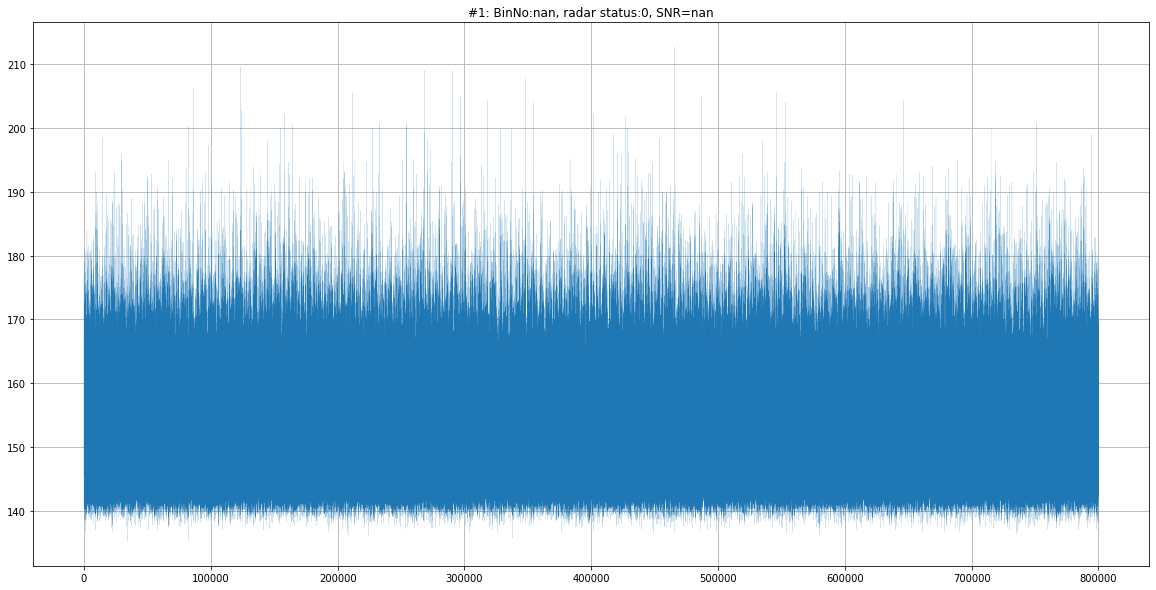

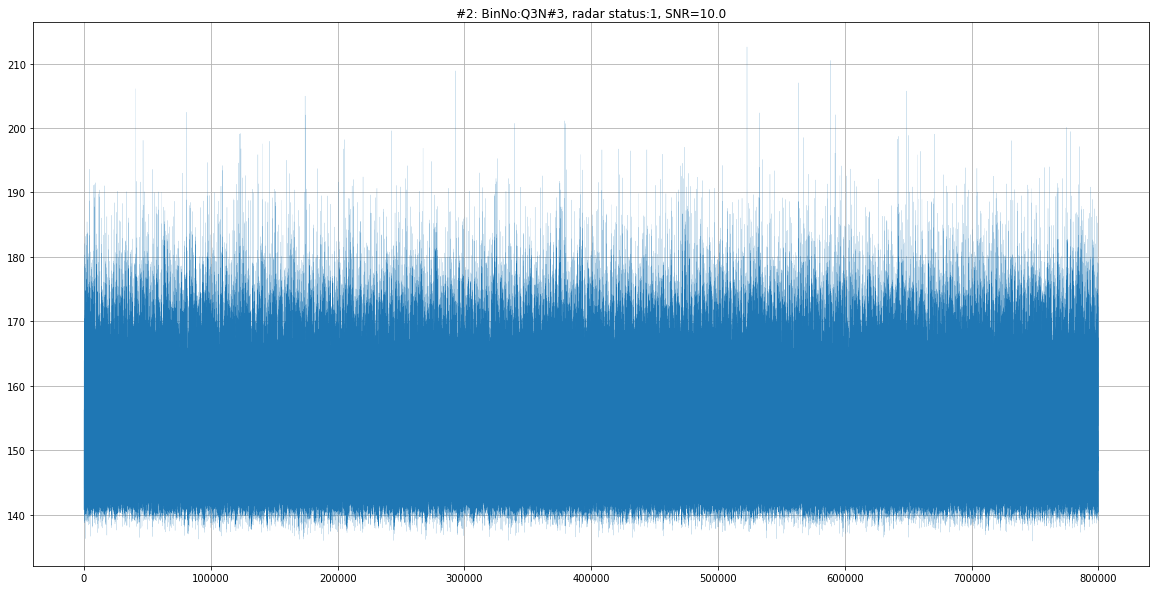

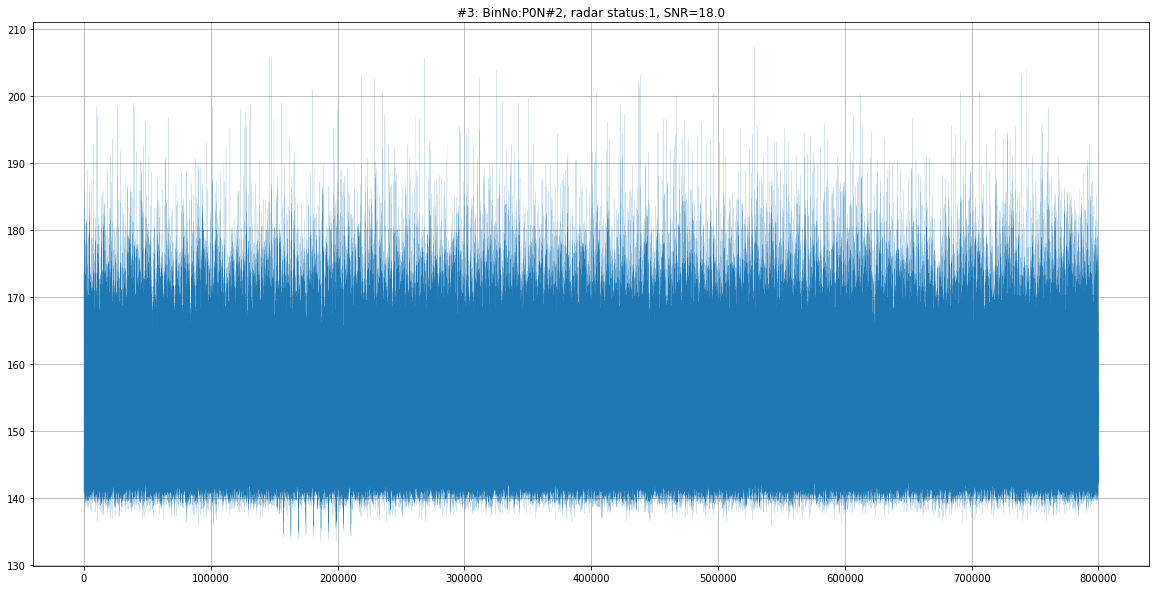

In [61]:
noExamples=3
startFrom=1
for sigIndex in range(startFrom,startFrom+noExamples):
      #sigIndex=6 # Matlab index 6
      print('***Doing for sigIndex=', sigIndex)
      plt.figure(figsize=(20,10))
      plt.plot(-10*np.log(np.absolute(subsetSignals[sigIndex][0:-1])),linewidth=0.1)
      plt.title('#'+str(sigIndex)+': BinNo:'+str(subsetInfo['BinNo'][sigIndex])+', radar status:'+str(subsetInfo['radarStatus'][sigIndex])+', SNR='+str(subsetInfo['SNR'][sigIndex]))
      plt.grid()
print('***DONE!')

#Below we Plot Three Waveforms in the Frequency vs Time Domain. 

Again the first has only noise, the second has a relatively low SNR and the thrid a relatively higher SNR. Note that now the signal is resolved cells of time and frequency the signal can be seen as non-random cell patterns on top of the 'sea of noise'. It is hardly noticiable in the second case (SNR=10 dB), but still it can be seen lile a 'cat scratch' o lower left quadrant of the spectogram. In the case of the third spectorgram, the signal is much easier to see because of the higer SNR and also because the specific waveform used is short and 'shines more' above the noise 'sea level'

S.shape= (128, 446)
S.shape= (128, 446)
S.shape= (128, 446)
***DONE!


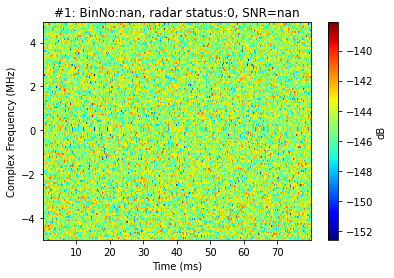

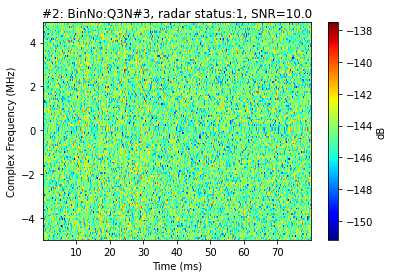

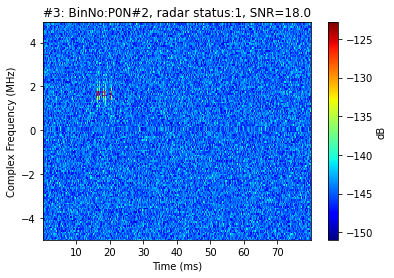

In [65]:
noExamples=3
startFrom=1
for sigIndex in range(startFrom,startFrom+noExamples):
  f, t0, S0 = signal.spectrogram(subsetSignals[sigIndex], fs=10e6, nperseg=Nfft, scaling='spectrum', return_onesided=False)
  #
  S0[0:1, :] = S0[1:2, :]
  L = S0.shape[1]/groupby
  S1 = np.reshape(S0[:,:int(L)*groupby], (Nfft,int(L),groupby))
  S = np.amax(S1, axis=-1)
  t = t0[groupby-1::groupby]
  
  print('S.shape=', S.shape)
  #S[0:1, :] = np.mean(S[70:80,:], axis=0)
  #S[0:1, :] = S[1:2, :]
  fshi = np.fft.fftshift(f/1e6) 
  Sshi = np.fft.fftshift(10.*np.log10(S), axes=0)
  #print('Sshi.shape=', Sshi.shape
  #
  #fig = plt.figure(figsize=(10,10))
  fig = plt.figure()
  cax = plt.pcolormesh(t*1e3, fshi, Sshi, cmap='jet')
  plt.title('#'+str(sigIndex)+': BinNo:'+str(subsetInfo['BinNo'][sigIndex])+', radar status:'+str(subsetInfo['radarStatus'][sigIndex])+', SNR='+str(subsetInfo['SNR'][sigIndex]))
  plt.xlabel('Time (ms)')
  plt.ylabel('Complex Frequency (MHz)')
  fig.colorbar(cax).set_label('dB')

print('***DONE!')

In [66]:
from scipy import signal
nruns=20
pca0 = 1
#noExamples=3
#startFrom=6
Nfft=128
groupby=16  # no. of consectuive FFTs over which to take max
#find signals with high SNR, e.g. SNR=20 dB
#highSNRIndex=np.where(subsetInfo.SNR==20)
#find signals with high SNR, e.g. SNR=10 dB

# [10. 12. 14. 16. 18. 20.]
#IselWaves=np.where(np.isnan(subsetInfo.SNR)) #Noise Only
#IselWaves=np.where(subsetInfo.SNR==10)
#IselWaves=np.where(subsetInfo.SNR==14)
#IselWaves=np.where(subsetInfo.SNR==16)
#IselWaves=np.where(subsetInfo.SNR==18)
IselWaves=np.where(subsetInfo.SNR==20)

idx=1
for I in np.nditer(IselWaves):
  if idx > nruns: break
  sigIndex=int(I)
  print('***-------------------')
  print('***Doing for sigIndex=', sigIndex, 'I=', I)
  print('...NSD   :', subsetInfo['NoisePowerdBmPerMHz'][sigIndex])
  print('...SNR   :', subsetInfo['SNR'][sigIndex])
  print('...BinNo :', subsetInfo['BinNo'][sigIndex])
  #
  f, t0, S0 = signal.spectrogram(subsetSignals[sigIndex], fs=10e6, nperseg=Nfft, scaling='spectrum', return_onesided=False)
  #
  S0[0:1, :] = S0[1:2, :]
  L = S0.shape[1]/groupby
  S1 = np.reshape(S0[:,:int(L)*groupby], (Nfft,int(L),groupby))
  S = np.amax(S1, axis=-1)
  t = t0[groupby-1::groupby]
  
  print('S.shape=', S.shape)
  #S[0:1, :] = np.mean(S[70:80,:], axis=0)
  #S[0:1, :] = S[1:2, :]
  fshi = np.fft.fftshift(f/1e6) 
  Sshi = np.fft.fftshift(10.*np.log10(S), axes=0)
  #print('Sshi.shape=', Sshi.shape)
  
  if 0: #Controls the printing of the Spectograms
    fig = plt.figure()
    cax = plt.pcolormesh(Sshi.T.dot(Sshi), cmap='jet')
    plt.title('Run# '+str(idx)+' '+str(subsetInfo['BinNo'][sigIndex])+' TIME')
    plt.xlabel('Time (ms)')
    plt.ylabel('Complex Frequency (MHz)')
    fig.colorbar(cax).set_label('dB')
    #
    fig = plt.figure()
    cax = plt.pcolormesh(Sshi.dot(Sshi.T), cmap='jet')
    plt.title('Run# '+str(idx)+' '+str(subsetInfo['BinNo'][sigIndex])+' TIME')
    plt.xlabel('Time (ms)')
    plt.ylabel('Complex Frequency (MHz)')
    fig.colorbar(cax).set_label('dB')
    #

  if 1: #Controls the printing of the Spectograms
    fig = plt.figure()
    cax = plt.pcolormesh(t*1e3, fshi, Sshi, cmap='jet')
    plt.title('Run# '+str(idx)+' '+str(subsetInfo['BinNo'][sigIndex])+' TIME')
    plt.xlabel('Time (ms)')
    plt.ylabel('Complex Frequency (MHz)')
    fig.colorbar(cax).set_label('dB')
    #

  if 1: #Controls the printing of the stem with the PCAs
    ##u, s, vh = np.linalg.svd(Sshi, full_matrices=False);
    #u, s, vh = np.linalg.svd(Sshi.T, full_matrices=False);
    u, s, vh = np.linalg.svd(Sshi.T.dot(Sshi), full_matrices=False);
    aux = 100*np.sort(s)[::-1]/np.sum(s)
    print(aux[0+pca0:10])
    fig = plt.figure()
    #plt.stem(np.log10(s[0+pca0:50]))
    plt.stem(aux[0+pca0:50])
    plt.title('Run# '+str(idx)+' '+str(subsetInfo['BinNo'][sigIndex])+' FREQ')

  print('...#%02d'%sigIndex,':','Min =', 10.*np.log10(min(S.flat)),'\n.........Max =', 10.*np.log10(max(S.flat)))
  idx += 1;
  # end of for()

print('***DONE!')

Output hidden; open in https://colab.research.google.com to view.